In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Compressor:
    
    def __init__(self, *, threshold, ratio, knee):
        self.threshold = threshold
        self.ratio = ratio
        self.knee = knee
        
    def get_gain_reduction(self, x):
        g = (1 - (1 / self.ratio)) # ratio as a factor
        t = self.threshold
        w = self.knee
        l = t - w / 2 # soft knee lower bound
        u = t + w / 2 # soft knee upper bound
        if x <= l: # below knee
            return 0
        if x >= u: # above knee
            return (x - t) * g
        k = (x - l) / w # position along knee (0..1)
        return (x - l) * g * k / 2

In [3]:
def decibels_to_gain(x):
    if x > float("-inf"):
        return 10 ** (x / 20)
    return 0

In [4]:
import math

def gain_to_decibels(x):
    if x > 0:
        return math.log10(x) * 20
    return float("-inf")

# Transfer function

In [5]:
def plot_transfer_function(f, x0, x1, y0, y1, *, T, R, W):
    x = np.linspace(x0, x1, 1000)
    y = [i - f(i) for i in x]
    plt.plot([T, T], [y0, y1], color="red", label=f"Threshold ({T} dB)")
    plt.plot([x0, x1], [T, T], ":", color="red")
    if W:
        plt.plot([T - W / 2, T - W / 2], [y0, y1], ":", color="green", label=f"Knee ({W} dB)")
        plt.plot([T + W / 2, T + W / 2], [y0, y1], ":", color="green")
        plt.plot([T - W / 2, T], [T - W / 2, T], "--", color="black", label="Hard knee")
        plt.plot([T, T + W / 2],  [T, T + W / 2 - f(T + W / 2)], "--", color="black")
    plt.plot(x, y, color="blue", linewidth=4)
    plt.xlim(x0, x1)
    plt.ylim(y0, y1)
    plt.plot([x0, x1], [T - T / R, T - T / R], color="orange", label=f"Final gain reduction ({T - T / R} dB)")
    plt.legend()
    plt.ylabel("Output level (dB)")
    plt.xlabel("Input level (dB)")
    plt.show()
    
print()

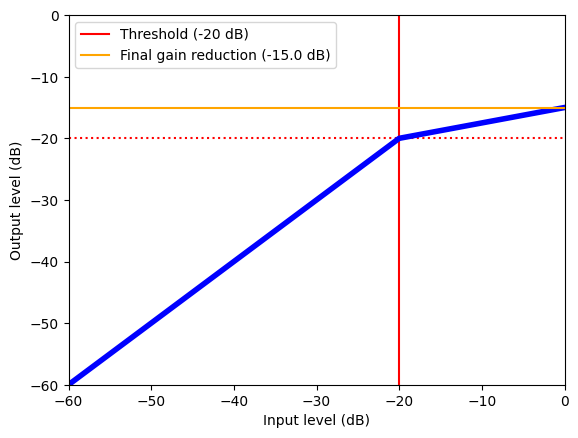

In [6]:
c = Compressor(threshold=-20, ratio=4, knee=0)
f = lambda x: c.get_gain_reduction(x)
plot_transfer_function(f, -60, 0, -60, 0, T=-20, R=4, W=0)

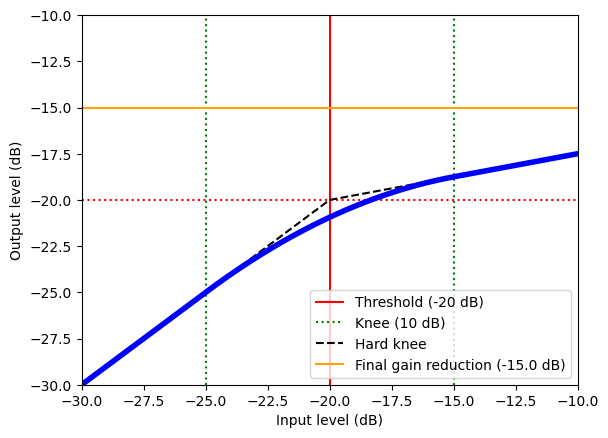

In [7]:
c = Compressor(threshold=-20, ratio=4, knee=10)
f = lambda x: c.get_gain_reduction(x)
plot_transfer_function(f, -30, -10, -30, -10, T=-20, R=4, W=10)

# Envelope detector

In [25]:
class EnvelopeDetector:
    
    def __init__(self, *, attack, release, rms=False, fs):
        self.attack = attack
        self.release = release
        self.rms = rms
        self.fs = fs
        self.attack_coeff = math.exp(math.log(0.368) / (self.attack * self.fs))
        self.release_coeff = math.exp(math.log(0.368) / (self.release * self.fs))
        self.reset()
        
    def reset(self):
        self.envelope = 0
    
    def get_envelope(self, y):
        y = abs(y)
        if self.rms:
            y *= y
        if y > self.envelope:  # rising
            envelope = self.attack_coeff * (self.envelope - y) + y
        else:  # falling
            envelope = self.release_coeff * (self.envelope - y) + y
        envelope = min(envelope, 1.0)
        envelope = max(envelope, 0.0)
        self.envelope = envelope
        if self.rms:
            envelope **= 0.5
        return envelope

In [26]:
def generate_sine(frequency, duration, *, fs):
    x = np.linspace(0, duration, int(duration * fs), endpoint=False)
    y = np.sin(2 * np.pi * x * frequency)
    return y

In [27]:
def generate_test_signal(f, d0, a0, d1, a1, d2, a2, *, fs):
    y = np.concatenate([
        generate_sine(f, d0, fs=fs) * decibels_to_gain(a0),
        generate_sine(f, d1, fs=fs) * decibels_to_gain(a1),
        generate_sine(f, d2, fs=fs) * decibels_to_gain(a2),
    ])
    return np.linspace(0, d0 + d1 + d2, len(y)), y

In [53]:
def plot_signal(frequency, d0, a0, d1, a1, d2, a2, *, threshold, ratio, knee, attack, release, fs):
    c = Compressor(threshold=threshold, ratio=ratio, knee=knee)
    f = lambda x: decibels_to_gain(c.get_gain_reduction(gain_to_decibels(x)))
    x, y = generate_test_signal(frequency, d0, a0, d1, a1, d2, a2, fs=fs)
    plt.plot(x, y, color="silver", label="Input signal")
    e = EnvelopeDetector(attack=attack, release=release, fs=fs, rms=False)
    plt.plot(x, [i / f(e.get_envelope(i)) for i in y], color="blue", label="Output signal (Peak)")
    e = EnvelopeDetector(attack=attack, release=release, fs=fs, rms=True)
    plt.plot(x, [i / f(e.get_envelope(i)) for i in y], color="orange", label="Output signal (RMS)")
    e = EnvelopeDetector(attack=attack, release=release, fs=fs, rms=False)
    plt.plot(x, [e.get_envelope(i) for i in y], color="black", label="Envelope (Peak)")
    e = EnvelopeDetector(attack=attack, release=release, fs=fs, rms=True)
    plt.plot(x, [e.get_envelope(i) for i in y], ":", color="black", label="Envelope (RMS)")
    plt.plot([d0, d0], [-1.2, 1.2], ":", color="green")
    plt.plot([d0 + attack, d0 + attack], [-1.2, 1.2], ":", color="green", label=f"Attack ({attack * 1000:.0f} ms)")
    plt.plot([d0 + d1, d0 + d1], [-1.2, 1.2], ":", color="red")
    plt.plot([d0 + d1 + release, d0 + d1 + release], [-1.2, 1.2], ":", color="red", label=f"Release ({release * 1000:.0f} ms)")
    plt.xlabel("Seconds")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

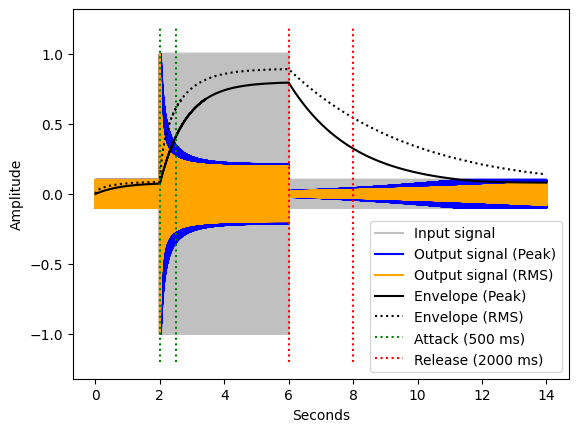

In [54]:
plot_signal(500.0, 2, -20, 4, 0, 8, -20, threshold=-20, ratio=4, knee=0, attack=0.5, release=2.0, fs=2000)